(transit)=

# Transit Fitting

Like `exoplanet`, `jaxoplanet` includes methods for computing the light curves of transiting exoplanets. In this tutorial, we introduce these methods and use it alongside the `NumPyro` probabilistic programming library to do some transit fitting. Parts of this tutorial will follow the [Transit Fitting tutorial](https://gallery.exoplanet.codes/tutorials/transit/) for the `exoplanet` package.

```{note}
This tutorial requires some [extra packages](about.ipynb) that are not included in the `jaxoplanet` dependencies.
```

## Setup

We first setup the number of CPUs to use and enable the use of double-precision numbers with jax. We also import the required packages.

In [1]:
import jax
import numpyro

# For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_host_device_count(2)

# For CPU (use "gpu" for GPU)
numpyro.set_platform("cpu")

# For 64-bit precision since JAX defaults to 32-bit
jax.config.update("jax_enable_x64", True)

## Generating the data

Let's first compute a simple light curve.

The light curve calculation requires an orbit object. We'll use [TransitOrbit](jaxoplanet.orbits.transit.TransitOrbit) (similar to [SimpleTransitOrbit](https://docs.exoplanet.codes/en/latest/user/api/#exoplanet.orbits.SimpleTransitOrbit) in the exoplanet package), which is an orbit parameterized by the observables of a transiting system: period, speed/duration, time of transit, impact parameter, and radius ratio.

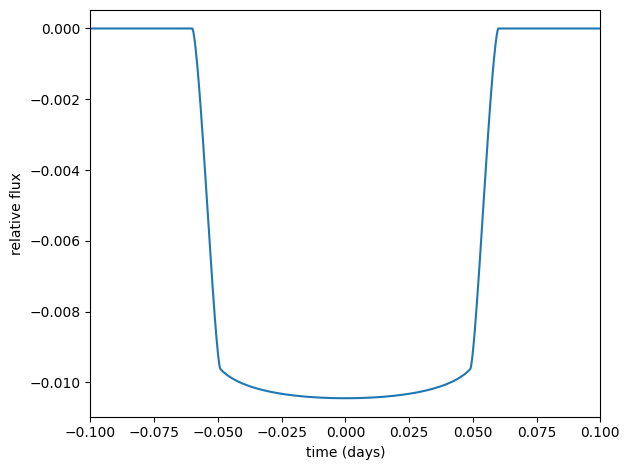

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from jaxoplanet.orbits import TransitOrbit
from jaxoplanet.light_curves import limb_dark_light_curve

orbit = TransitOrbit(
    period=3.456, duration=0.12, time_transit=0.0, impact_param=0.0, radius_ratio=0.1
)

# Compute a limb-darkened light curve for this orbit
time = np.linspace(-0.1, 0.1, 1000)
u = [0.1, 0.06]  # Quadratic limb-darkening coefficients
light_curve = limb_dark_light_curve(orbit, u)(time)

# Plot the light curve
plt.plot(time, light_curve)
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
plt.tight_layout()

## Transit model in NumPyro

We'll construct a transit model using `NumPyro` and fit to some simulated data. `NumPyro` is a probabilistic programming library (PPLs) like `PyMC` that allows us to succinctly build models and perform (gradient-based) inference with them. **NumPyro models must be written in JAX!**


Let's start off by choosing the transit properties of our simulated data. These will be the "true" values that we would like to recover with our inference. 
<!-- To make our lives easier let's set the impact parameter $b$ to be 0.  -->

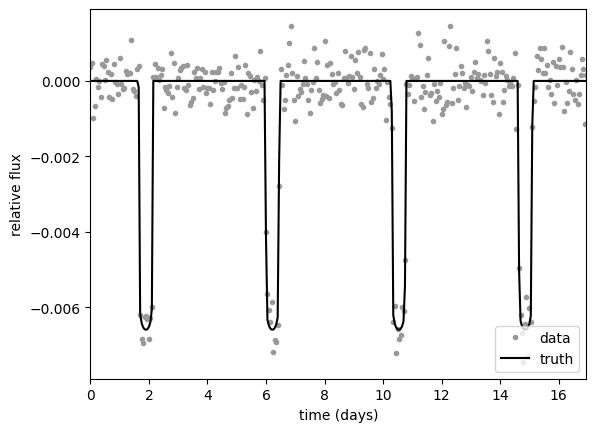

In [60]:
# Simulate some data with Gaussian noise
random = np.random.default_rng(42)
PERIOD = random.uniform(2, 5)  # day
T0 = PERIOD * random.uniform()  # day
DURATION = 0.5  # day
B = 0.5  # impact parameter
ROR = 0.08  # planet radius / star radius
U = np.array([0.1, 0.06])  # limb darkening coefficients
yerr = 5e-4  # flux uncertainty
time = np.arange(0, 17, 0.05)  # day


orbit = TransitOrbit(
    period=PERIOD, duration=DURATION, time_transit=T0, impact_param=B, radius_ratio=ROR
)
y_true = limb_dark_light_curve(orbit, U)(time)
y = y_true + yerr * random.normal(size=len(time))

# Let's see what the light curve looks like
plt.plot(time, y, ".", c="0.6", label="data")
plt.plot(time, y_true, "-k", label="truth")
plt.xlabel("time (days)")
plt.ylabel("relative flux")
plt.xlim(time.min(), time.max())
_ = plt.legend(loc=4)

## Defining the model

Let's define our numpyro model. The syntax for numpyro might be a bit unfamiliar, but here it is.
We're sampling the period and duration in log space to constrain it to positive values, and we're also sampling the quadratic limb darkening coefficients using the custom distribution `QuadLDParams` in the `numpyro_ext` package.

In [13]:
import numpyro_ext
import jax.numpy as jnp


def light_curve_model(time, params):
    orbit = TransitOrbit(
        period=params["period"],
        duration=params["duration"],
        time_transit=params["t0"],
        impact_param=params["b"],
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, params["u"])(time)


def model(t, yerr, y=None):
    # Priors for the parameters we're fitting for

    # The time of reference transit
    t0 = numpyro.sample("t0", numpyro.distributions.Normal(T0, 1))

    # The period
    logP = numpyro.sample("logP", numpyro.distributions.Normal(jnp.log(PERIOD), 0.1))
    period = numpyro.deterministic("period", jnp.exp(logP))

    # The duration
    logD = numpyro.sample("logD", numpyro.distributions.Normal(jnp.log(DURATION), 0.1))
    duration = numpyro.deterministic("duration", jnp.exp(logD))

    # The radius ratio
    # logR = numpyro.sample("logR", numpyro.distributions.Normal(jnp.log(ROR), 0.1))
    r = numpyro.sample("r", numpyro.distributions.Uniform(0.01, 0.2))
    # r = numpyro.deterministic("r", jnp.exp(logR))

    # The impact parameter
    # b = numpyro.sample("b", numpyro.distributions.Uniform(0, 1.0))
    _b = numpyro.sample("_b", numpyro.distributions.Uniform(0, 1.0))
    b = numpyro.deterministic("b", _b * (1 + r))

    # The limb darkening coefficients
    u = numpyro.sample("u", numpyro_ext.distributions.QuadLDParams())

    # The orbit and light curve
    y_pred = light_curve_model(
        t, {"period": period, "duration": duration, "t0": t0, "b": b, "r": r, "u": u}
    )

    # Let's track the light curve
    numpyro.deterministic("light_curve", y_pred)

    # The likelihood function assuming Gaussian uncertainty
    numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

## Checking the priors

It can be a good idea to see whether the priors we defined are reasonable by sampling and plotting them. Let's do that now using the `numpyro.infer` submodule's `Predictive` functionality to draw some samples from the priors.

In [14]:
import arviz as az

n_prior_samples = 3000
prior_samples = numpyro.infer.Predictive(model, num_samples=n_prior_samples)(
    jax.random.PRNGKey(0), time, yerr
)

# Let's make it into an arviz InferenceData object.
# To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
converted_prior_samples = {
    f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
}
prior_samples_inf_data = az.from_dict(converted_prior_samples)

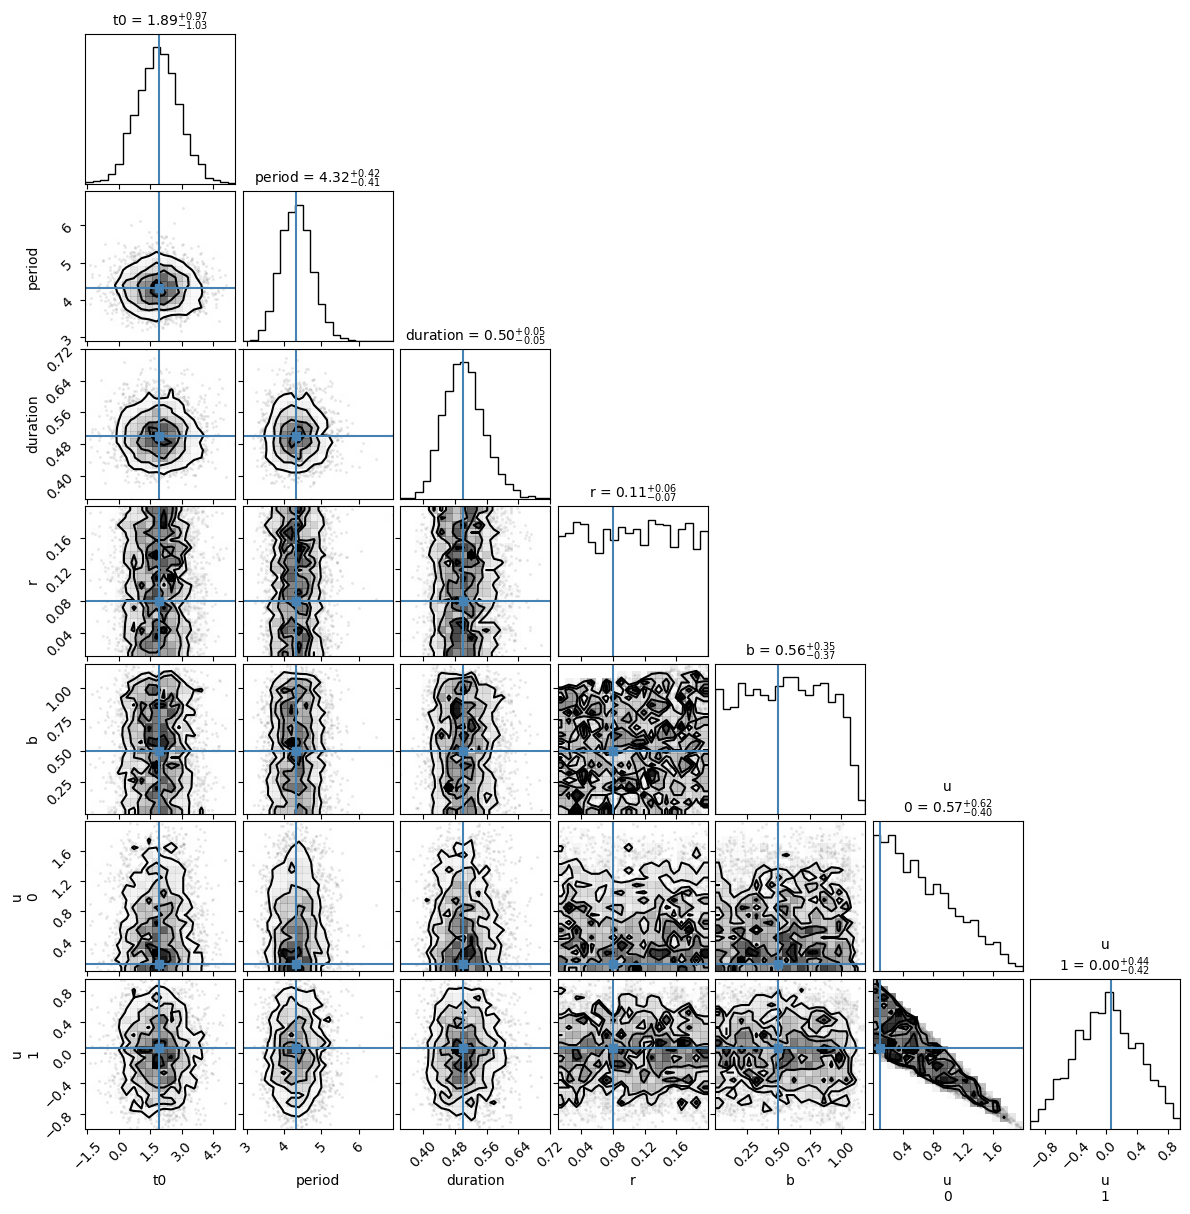

In [15]:
import corner

# Plot the corner plot
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    prior_samples_inf_data,
    fig=fig,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    truths=[T0, PERIOD, DURATION, ROR, B, U[0], U[1]],
    show_titles=True,
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
)

These priors seems sensible enough and the true values (blue lines) are within their bounds. Before we start sampling, let's find the maximum a posteriori (MAP) solution. This is a good starting point for the sampling we'll perform later and also a good check to see if things are working.
We'll use the `optimize` function defined within the `numpyro_ext` package.

We have a choice for the inital value of the optimization. Some potential options include:
1. Manually setting them to a specific set of values. This approach might make sense for real data when it's a system that's been studied before and there's a good guess for the parameters. As an example, if we were fitting some follow-up ground-based transit data it might make sense to use the parameters from a Kepler/TESS discovery paper as the initial values.
2. The median values of the priors. This might be a good idea when we don't have a good guess for the parameters. Similarly, we could also use the mean values of the priors.

Let's do the former and set the initial values to the true values. 
<!-- Let's do the latter and set the initial values to the median values of the priors. -->

In [16]:
init_param_method = "true_values"  # "prior_median" or "true_values"

if init_param_method == "prior_median":
    print("Starting from the prior medians")
    run_optim = numpyro_ext.optim.optimize(
        model, init_strategy=numpyro.infer.init_to_median()
    )
elif init_param_method == "true_values":
    print("Starting from the true values")
    init_params = {
        "t0": T0,
        "logP": jnp.log(PERIOD),
        "logD": jnp.log(DURATION),
        "logR": jnp.log(ROR),
        "_b": B / (1 + ROR),
        "u": U,
    }
    run_optim = numpyro_ext.optim.optimize(
        model,
        init_strategy=numpyro.infer.init_to_value(values=init_params),
    )

opt_params = run_optim(jax.random.PRNGKey(5), time, yerr, y=y)

Starting from the true values


In [17]:
for k, v in opt_params.items():
    if k in ["light_curve", "obs", "_b"]:
        continue
    print(f"{k}: {v}")

t0: 1.9000778724033893
logP: 1.4632457135160681
logD: -0.6800678396181121
r: 0.08058698917719072
u: [ 0.24748829 -0.12374414]
b: 0.593890499514442
duration: 0.5065826248280519
period: 4.319958144846175


Now let's plot the MAP model against the simulated data.

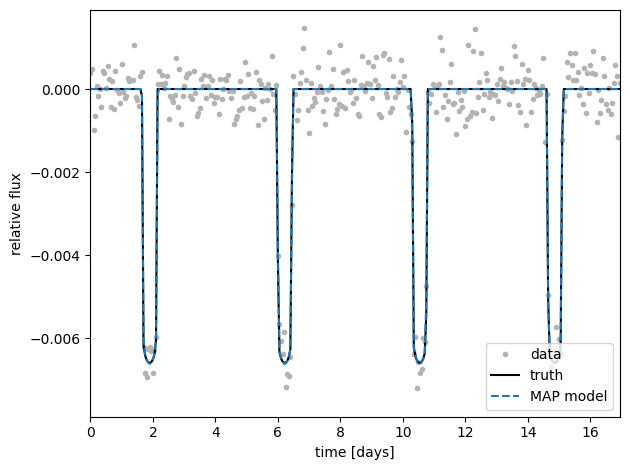

In [50]:
plt.plot(time, y, ".", c="0.7", label="data")
plt.plot(time, y_true, "-k", label="truth")
plt.plot(time, opt_params["light_curve"], "--C0", label="MAP model")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.legend(fontsize=10, loc=4)
plt.xlim(time.min(), time.max())
plt.tight_layout()

Great. Not surprisingly, the MAP model is  a good fit to the data.
Let's use these MAP values as the initial values for our sampling.

## Sampling
Let's sample from the posterior defined by this model and data. We'll use the No-U-Turn Sampler (NUTS) algorithm, which is a variant of the Hamiltonian Monte Carlo (HMC) algorithm that automatically tunes some of the sampling parameters.

This cell takes about a minute to run on my laptop. Don't worry if it doesn't seem like anything is happening for a while at the beginning; compiling the code and running the first 100-200 iterations are the most computationally demanding and the subsequent sampling runs much faster!

Below, we're setting the ``regularize_mass_matrix`` keyword to ``False``. This is because we realized that the default of setting it to ``True`` causes the sampling to be slower (roughly 4 times slower). We're investigating why but it seems (at least for this case) the posteriors are pretty much the same whether you regularize the mass matrix or not.

In [30]:
sampler = numpyro.infer.MCMC(
    numpyro.infer.NUTS(
        model,
        dense_mass=True,
        regularize_mass_matrix=False,
        init_strategy=numpyro.infer.init_to_value(values=opt_params),
    ),
    num_warmup=1000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)

sampler.run(jax.random.PRNGKey(1), time, yerr, y=y)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

## Checking our posterior samples

We should check the convergence of our sampler. Determining whether a sampler has converged is not trivial and there is a lot of literature on the subject. Here we'll attempt to check for convergence by looking at the the Gelman-Rubin $\hat{R}$ statistic and the bulk effective sample size (ESS) of each parameter. 

- The [$\hat{R}$ statistic](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html) is a diagnostic of convergence based on the ratio of the variance between chains to the variance within chains. We would like for it to be close to 1.00 for each parameter. 
- The [ESS](https://mc-stan.org/docs/2_18/reference-manual/effective-sample-size-section.html) is a measure of the number of independent samples in the chains and is inversely correlated with the autocorrelation in a chain. Larger estimates for the ESS are better as they indicate less autocorrelation in the chains.

We can get both of these values using the `summary` function in the `Arviz` package. Let's do that now.

In [31]:
inf_data = az.from_numpyro(sampler)
samples = sampler.get_samples()
az.summary(inf_data, var_names=["t0", "period", "duration", "r", "b", "u"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t0,1.901,0.003,1.895,1.906,0.000,0.000,1808.0,1606.0,1.00
period,4.320,0.002,4.317,4.323,0.000,0.000,2046.0,1463.0,1.00
duration,0.504,0.006,0.493,0.516,0.000,0.000,1318.0,1690.0,1.00
r,0.079,0.001,0.077,0.081,0.000,0.000,669.0,1702.0,1.00
b,0.428,0.175,0.073,0.658,0.008,0.006,547.0,748.0,1.01
u[0],0.155,0.112,0.000,0.356,0.002,0.002,2523.0,2427.0,1.00
u[1],0.155,0.208,-0.182,0.552,0.006,0.004,1344.0,1764.0,1.00


The ESS (`ess_bulk`) isn't great for some of the parameters, like the duration and the impact parameter $b$, but since the $\hat{R}$ values are good let's just go ahead with these samples.

In [32]:
# There's also a method to obtain similar results to `az.summary` but directly
# as a method with the MCMC sampler. It also gives us the number of divergences.
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        _b      0.40      0.16      0.45      0.12      0.62    484.42      1.01
      logD     -0.68      0.01     -0.68     -0.71     -0.67   1273.29      1.00
      logP      1.46      0.00      1.46      1.46      1.46   1768.77      1.00
         r      0.08      0.00      0.08      0.08      0.08    624.98      1.00
        t0      1.90      0.00      1.90      1.90      1.90   1755.31      1.00
      u[0]      0.16      0.11      0.13      0.00      0.31   2576.72      1.00
      u[1]      0.16      0.21      0.13     -0.17      0.47   1242.71      1.00

Number of divergences: 0


Let's get a different view of the chains by making some trace plots. We can do this using the `plot_trace` function in the `Arviz` package.

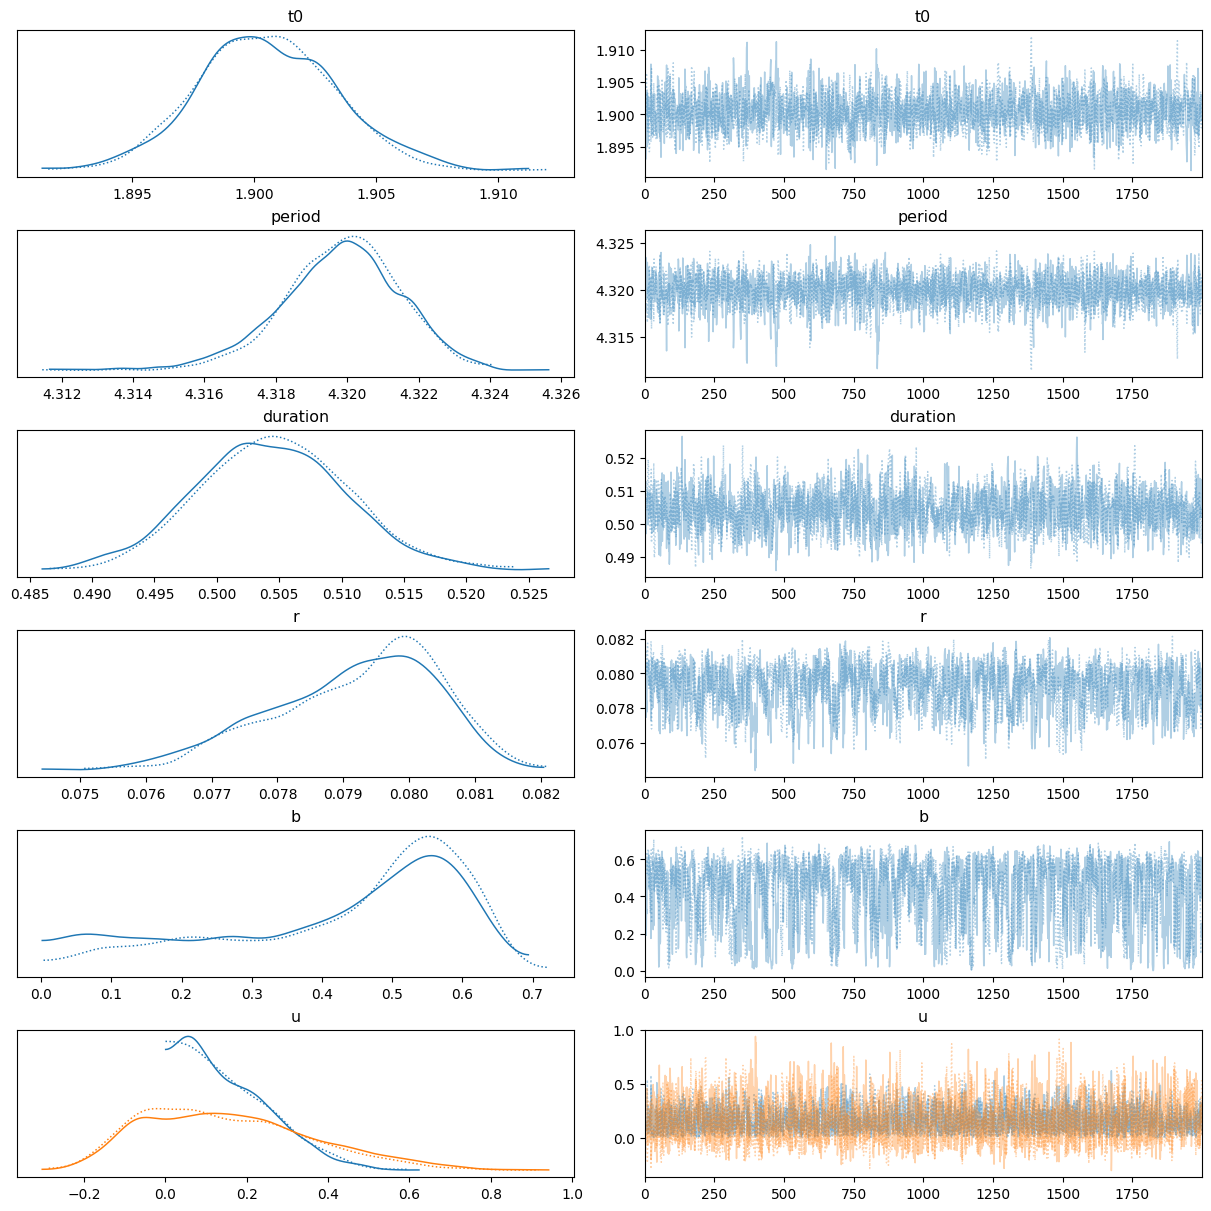

In [33]:
_ = az.plot_trace(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    backend_kwargs={"constrained_layout": True},
)

The different line styles (not colors!) above indicate the different chains. There's two colors for $u$ since there are two limb-darkening coefficients (i.e., $u_1, u_2$).

Let's now make a corner plot of the posterior samples to see the pairwise joint distributions of the parameters and see if there are any correlations.

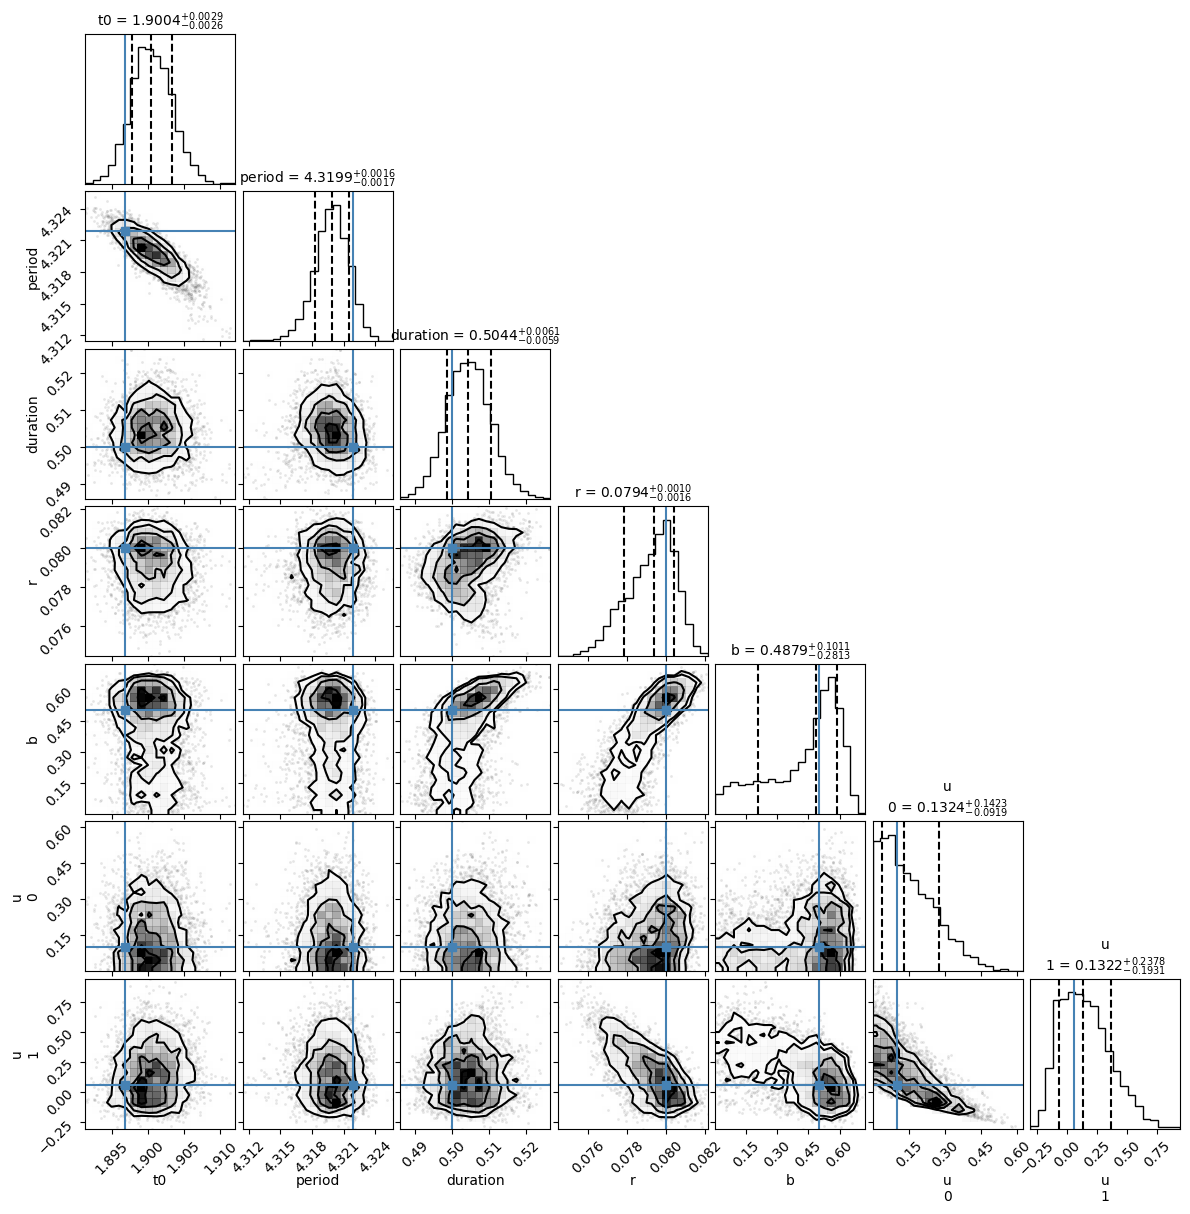

In [34]:
fig = plt.figure(figsize=(12, 12))
_ = corner.corner(
    inf_data,
    var_names=["t0", "period", "duration", "r", "b", "u"],
    truths=[T0, PERIOD, DURATION, ROR, B, U[0], U[1]],
    show_titles=True,
    quantiles=[0.16, 0.5, 0.84],
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 10},
    title_fmt=".4f",
    fig=fig,
)

The blue lines indicate the true values. All the true values are within 1-sigma of the marginalized posterior distributions, which is good!

## Phase plots
Let's make the phase plot that is commonly shown in exoplanet papers.

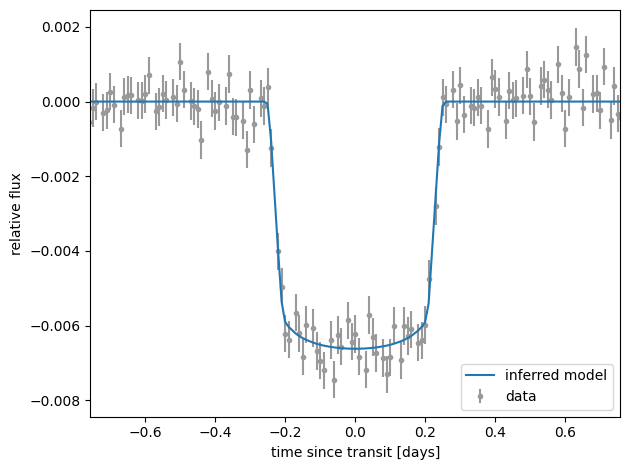

In [59]:
inferred_params = {
    "t0": np.median(samples["t0"]),
    "period": np.median(samples["period"]),
    "duration": np.median(samples["duration"]),
    "r": np.median(samples["r"]),
    "b": np.median(samples["b"]),
    "u": np.median(samples["u"], axis=0),
}


y_model = light_curve_model(time, inferred_params)

fig, ax = plt.subplots()

# Plot the folded data
t_fold = (
    time - inferred_params["t0"] + 0.5 * inferred_params["period"]
) % inferred_params["period"] - 0.5 * inferred_params["period"]
ax.errorbar(t_fold, y, yerr=yerr, fmt=".", color="0.6", label="data", zorder=-100)

# Plot the folded model
inds = np.argsort(t_fold)
ax.plot(t_fold[inds], y_model[inds], color="C0", label="inferred model")
ax.set_xlim(inferred_params["duration"] * jnp.array([-1, 1]) * 1.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("relative flux")
ax.legend(loc=4)
plt.tight_layout()